การเทรนโมเดลในงาน Sentiment Analysis ซึ่งเป็นสาขาหนึ่งของ Natural Language Processing (NLP) ของเรานี้ เราจะใช้อัลกอริทึ่มที่เรียกว่า ULMFiT ย่อมาจาก Universal Language Model Fine-tuning เป็นการนำ Transfer Learning ที่ใช้กันอย่างแพร่หลายใน Computer Vision มาประยุกต์ใช้กับ NLP ช่วยให้เทรนได้เร็วขึ้น ได้ผลแม่นยำมากขึ้น มีขึ้นตอนดังนี้

1. สร้าง หรือดาวน์โหลด Language Model ที่เทรนกับ Corpus ขนาดใหญ่ เช่น Wikipedia

2. Fine-tune โมเดล Language Model นี้เข้ากับ Corpus ของเรา เช่น รีวิวหนัง

3. ดึง Encoder ออกจาก Language Model ที่ Fine-tune แล้ว มาใช้สร้าง Classifier

4. Fine-tune โมเดล Classifier ด้วยวิธีปกติ ในกรณีนี้คือ Sentiment Analysis


*Language Model คือ โมเดลภาษา การเข้าใจภาษา บางทีต้องเข้าใจโลกของภาษานั้น ๆ ด้วย ตัวอย่างคือ สามารถเดาคำในช่องว่างได้ เช่น หมาตัวนี้สี..., แมนยูกำลังให้ความสนใจดาวยิงชาวสเปนอย่าง..., President Obama fought unsuccessfully to restrict gun ...*


# 0. Magic Commands


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

เคสนี้เราจะใช้ fastai.text ซึ่งเป็น Library ทางด้าน NLP

In [2]:
from fastai import *
from fastai.text import *

# 2. ข้อมูลตัวอย่าง

เราจะใช้ชุดข้อมูล [Large Movie Review Dataset v1.0](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.bib) จาก  Andrew Maas et al.  http://ai.stanford.edu/~amaas/data/sentiment/

ชุดข้อมูลนี้ประกอบด้วย 

1. รีวิวหนัง ที่มี Label แง่บวก/แง่ลบ สำหรับเทรน จำนวน 25,000 รีวิว
2. รีวิวหนัง ที่มี Label แง่บวก/แง่ลบ สำหรับเทส จำนวน 25,000 รีวิว
3. รีวิวหนัง ที่ไม่มี label จำนวน 50,000 รีวิว

หมายเหตุ

1. รีวิวหนังถูกเลือกมาแล้ว ให้ชัดเจน ว่าเขียนแง่บวก หรือแง่ลบ ไม่กำกวม
2. รีวิวหนังที่ไม่มี Label ไม่ใช่ไม่มีประโยชน์ เราจะใช้มาช่วยเทรน Language Model ใน ULMFiT ในขั้นตอนที่ 2

เปิดข้อมูล Sample ดูก่อน ที่จะไปดูข้อมูลจริง

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/home/jupyter/.fastai/data/imdb_sample/data_save.pkl')]

มี CSV อยู่ไฟล์เดียว ลองเปิดดู head (5 บรรทัดแรก)

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


ข้อมูลมี 3 column คือ label แง่บวกหรือลบ, text คือข้อความรีวิว และ is_valid คือ เป็น Validation Set หรือ Training Set

แต่ text ยาวมากเกินไป เวลาแสดงถูกตัดออกไป เรามาดูเฉพาะ text บรรทัดที่ 2 กัน

In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

สร้าง Databunch แบบ TextDataBunch 

เนื่องจากโมเดลไม่สามารถประมวลผลข้อความได้โดยตรง โมเดลรับได้แต่ตัวเลข เราจึงต้องแปลงข้อความความให้เป็นตัวเลขเสียก่อน ด้วย 2 ขั้นตอนดังนี้

1. Tokenization คือ การนำข้อความมาตัดคำ ออกเป้นคำย่อย ๆ เรียกว่า Token 
2. Numericalization คือ การกำหนดค่าแต่ละ Token แทนด้วยตัวเลข

TextDataBunch จะดำเนินการทั้ง 2 ขั้นตอนให้อัตโนมัติ

In [6]:
databunch_languagemodel = TextDataBunch.from_csv(path, 'texts.csv')

Save databunch ที่เราแปลงไว้

In [7]:
databunch_languagemodel.save()

คราวหน้าจะได้ไม่ต้องแปลงใหม่ สามารถ Load ขึ้นมาได้เลย

In [8]:
databunch_languagemodel = load_data(path)

# 3. เตรียมข้อมูลตัวอย่าง

เรามาดูการทำงานทีละขั้นตอนกันโดยละเอียด

## Tokenization

ขั้นตอนแรกในการประมวลผลข้อความต่าง ๆ คือ Split ประโยค ให้แบ่งเป็นหน่วยย่อย ๆ คำย่อย ๆ เรียกว่า Token ในกรณีภาษาอังกฤษ สามารถแบ่งตาม space ได้เลย แต่ก็มีกรณีพิเศษ เช่น

1. Punctuation เช่น . ? , : ' ; - " ( ) etc.
2. Contraction เช่น should've/should have, can't/cannot, don't/do not, I'm/I am, couldn't/could not, you've/you have, she's/she is, who's/who is, doesn't/does not, they're/they are
3. ภาษาพิเศษ ที่ปนอยู่ในข้อความ เช่น HTML, Markdown, Tag พิเศษ

เรามาดูกันว่า ผลลัพธ์หลังจาก Tokenization แล้ว ข้อความจะเป็นอย่างไร

In [9]:
databunch_languagemodel = TextLMDataBunch.from_csv(path, 'texts.csv')

x,y = next(iter(databunch_languagemodel.train_dl))
example = x[:15 ,:12].cpu()
texts = pd.DataFrame([databunch_languagemodel.train_ds.vocab.textify(l).split(' ') for l in example])
texts

,0,1,2,3,4,5,6,7,8,9,10,11
0,this,film,is,stolen,from,its,far,superior,predecessor,"""",xxmaj,the
1,xxunk,media,to,the,counter,-,culture,movement,.,xxmaj,dragnet,was
2,they,break,through,the,wall,to,get,to,the,safe,and,we
3,of,the,most,subtle,",",yet,loud,-,as,-,can,-
4,xxmaj,the,entire,second,half,is,only,redeemed,by,the,aforementioned,humour
5,.,xxmaj,predictably,",",xxmaj,morris,',students,maintain,their,end,of
6,you,imagine,that,seemingly,peaceful,neighborhood,with,all,these,awesome,characters,?
7,a,little,weak,though,.,xxmaj,both,xxmaj,danes,and,xxmaj,beckinsales
8,side,",",and,only,xxmaj,serbian,side,.,xxmaj,no,xxmaj,serbian
9,",",in,the,spy,vs,spy,variety,.,xxmaj,the,xxup,xxunk


สังเกตว่า

1. 's กลายเป็น 1 Token
2. Contraction กลายเป็น 2 Token เช่น is n't
3. Tag HTML ถูกลบไปหมด
4. มี Token พิเศษที่นำหน้าด้วย xx ปรากฏขึ้นมา เช่น xxbos = Begin of sentence, xxmaj = นำด้วยตัวใหญ่, xxunk คำที่ไม่มีใน Vocabulary

ความหมายของ Token พิเศษ ดังนี้

* UNK (xxunk) is for an unknown word (one that isn't present in the current vocabulary)
* PAD (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch
* BOS (xxbos) represents the beginning of a text in your dataset
* FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
* TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text
* TK_UP (xxup) is used to indicate the next word is written in all caps in the original text
* TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
* TK_WREP(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

Credit https://docs.fast.ai/text.transform.html

## Numericalization

หลังจากที่เราแปลงข้อความเป็น ลิสต์ของ Token เรียบร้อยแล้ว ขั้นตอนต่อมาเราจะแปลง Token เป็นตัวเลข โดยการสร้างตารางคำศัพท์ขึ้นมา เราจะนำ Token ทั้งหมดมาใส่ไว้ในตารางนี้ ตารางนี้อาจจะมีขนาดใหญ่เกินไป เราจึงใช้วิธีจำกัดจำนวน Vocabulary ดังนี้

1. ถ้า Token ไหน ปรากฎใน Corpus น้อยกว่า 2 ครั้ง จะถูกตัดทิ้ง แล้วแทนที่ด้วย UNK (xxunk)
2. Vocabulary เรียงตามที่ครั้งที่ปรากฎ มากไปน้อย ถ้าเกิน 60,000 (Default) ให้ตัดทิ้งไป

ทั้งนี้เพื่อรักษาขนาด Vocab ไม่ให้ใหญ่เกินไป เหมาะกับงาน และขนาด GPU ของเรา แต่ในการใช้งานแบบอื่น เช่น Google Translate อาจจะมีขนาด ถึงหลายล้าน Vocab x 100 ภาษา

เราสามารถดู Vocabulary ได้ว่าเลขไหน Assign ให้คำอะไร ด้วย Dictionary ชื่อ itos (int to String)

In [10]:
databunch_languagemodel.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',',
 '.',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

ถ้าเราดูข้อมูลใน databunch จะเห็นแยกเป็น Token เรียบร้อย

In [11]:
databunch_languagemodel.train_ds[0][0].text[:100]

"xxbos i wo n't waste a whole lot of time of this one because as far as i 'm concerned it is n't real"

ภายใต้รายการ Token เหล่านี้ คือตัวเลขที่ชี้ไปยังอันดับใน Vocabulary

In [12]:
databunch_languagemodel.train_ds[0][0].data[:15]

array([  2,  19, 505,  36, 488,  13, 218, 211,  14,  82,  14,  21,  43, 106,  27])

## Data Block

แทนที่เราจะใช้ TextClasDataBunch factory method เราจะเปลี่ยนมาใช้ Datablock API แทน เพื่อที่เราจะได้กำหนดค่าต่าง ๆ ได้ละเอียดยิ่งขึ้น 

เช่น ข้อมูลอยู่ column ไหน, split train/validation โดยดูจาก column ไหน, label อยู่ column ไหน ... ละเอียดไปถึง การกำหนด Tokenize และ Numericalize ในกรณีภาษาต่างประเทศ

In [11]:
databunch_classifier = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

# 2. ข้อมูลจริง


เมื่อเราเข้าใจ Concept แล้วก็มาเริ่มกันเลย

เนื่องจาก Language Model ใช้ GPU ค่อนข้างมาก เราควรกำหนดค่า Batch Size ให้ไม่ใหญ่เกินไป

In [13]:
batchsize=64

ดาวน์โหลด IMDB Dataset ตัวเต็ม

In [14]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/jupyter/.fastai/data/imdb/04a-databunch_languagemodel.pkl'),
 PosixPath('/home/jupyter/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jupyter/.fastai/data/imdb/04a-databunch_classifier.pkl'),
 PosixPath('/home/jupyter/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jupyter/.fastai/data/imdb/test'),
 PosixPath('/home/jupyter/.fastai/data/imdb/README'),
 PosixPath('/home/jupyter/.fastai/data/imdb/04a-data_languagemodel.pkl'),
 PosixPath('/home/jupyter/.fastai/data/imdb/models'),
 PosixPath('/home/jupyter/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup')]

ls ดูใน Folder train จะแบ่งเป็น Folder pos (Positive) และ neg (Negative)

In [15]:
(path/'train').ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/neg'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsupBow.feat')]

ls ดูใน pos ที่จะบรรจุไฟล์ txt ข้อความรีวิว ที่เป็นแง่บวกไว้ 

In [16]:
# (path/'train'/'pos').ls()

# 3. สร้างโมเดลภาษา Language Model



เราจะเอาข้อความรีวิวหนังทั้งหมดเท่าที่เรามี filter_by_folder จากทั้ง train, test และ unsup (Unsupervised ที่ไม่มี label) โดยยังไม่สนใจ label มาเทรนให้ Language Model ของเราเข้าใจภาษารีวิวหนังมากที่สุดเท่าที่จะเป็นไปได้

* split_by_rand_pct กำหนดให้กัน 10% ไว้เป็น Validation
* label_for_lm กำหนดให้ใช้ label สำหรับ Language Model หมายถึง ประโยคไหน label ก็คือ คำถัดไปของประโยคนั้น ไปเรื่อย ๆ

สร้าง databunch แปลง Tokenize, Numericalize แล้วเซฟไว้ คราวหน้าจะได้ไม่ต้องแปลงใหม่

In [ ]:
databunch_languagemodel = (TextList.from_folder(path)
            .filter_by_folder(include=['train', 'test', 'unsup']) 
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=batchsize))
databunch_languagemodel.save('04a-databunch_languagemodel.pkl')

โหลด databunch language model ที่แปลงไว้แล้วขึ้นมา

In [17]:
databunch_languagemodel = load_data(path, '04a-databunch_languagemodel.pkl', bs=batchsize)

ลองเรียกดูข้อมูลใน batch

In [18]:
databunch_languagemodel.show_batch()

idx,text
0,"in xxmaj xxunk . xxmaj there - initially much to his horror  xxmaj fosca , the grotesquely ugly cousin of his commander , develops an obsessive love for him . xxmaj he suffers her passionate and demanding displays of affection out of pity and concern for her health ( she is gravely ill ) , but becomes more and more fascinated by her  until the dramatic finale"
1,i ca n't blame him and i love the xxmaj gun that xxmaj charles uses . xxmaj death xxmaj wish 3 is one of the great movies of 1985 and ca n't get any better than this . \n \n i gives this 9 / 10 xxbos xxmaj turner and friends are closing in on xxup hbo for the top spot among made - for - xxup tv movie
2,"xxmaj guy . xxmaj bruno manipulating xxmaj guy may also take on other meanings . . . . \n \n 3 . xxmaj secrecy : xxmaj some have speculated about a sexual relationship between xxmaj guy and xxmaj bruno . xxmaj it seems at first ridiculous , especially since xxmaj guy appears obviously heterosexual in his relationships with xxmaj miriam and xxmaj anne . xxmaj however , remember that"
3,"reach of the impressionable market . xxmaj the super ( dated ? perhaps ' xxunk ' ) soundtrack helps and of course the cunning conceit of setting the film in a resort away from day to day life altogether finesses the fantasy . 7 / 10 xxbos i was really surprised to see that unlike most documentaries , this was written , directed and produced by a film xxunk xxmaj"
4,"( 1965 ) , xxmaj mulan ( 1998 ) , and xxmaj king xxmaj arthur ( 2004 ) . xxmaj alexander xxmaj nevsky was kept out of circulation due to changing political winds , and then enshrined as perhaps the most influential xxmaj soviet - made historical film . xxbos xxmaj if you are very sensitive when it comes to extreme racial stereotypes , this cartoon is not for you"


สร้าง language_model_learner ด้วย AWD-LSTM เป็นโมเดลแบบ RNN, LSTM ไว้เราจะอธิบายต่อไป

AWD_LSTM เป็น Language Model ที่ได้ถูกเทรนมากับ Corpus ขนาดใหญ่ จากส่วนหนึ่งของ Wikipedia ชื่อ WikiText-103 มีขนาดใหญ่ถึง 103,227,021 Token และ 267,735 Vocab เรียบร้อยแล้ว

กำหนดค่า drop_mult (Dropout) เรื่อง Regularization ไว้เราจะอธิบายต่อไป

In [19]:
learner = language_model_learner(databunch_languagemodel, 
                                 AWD_LSTM, drop_mult=0.3, 
                                 callback_fns=ShowGraph).to_fp16()


# 4. เริ่มต้นเทรน Language Model



เทรนด้วยค่า Default ไป 1 Epoch



epoch,train_loss,valid_loss,accuracy,time
0,4.115313,3.986427,0.297450,45:41


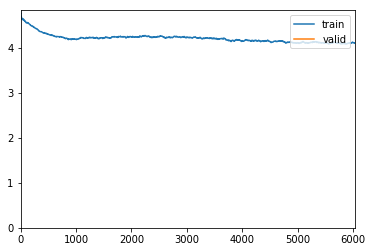

In [21]:
learner.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

เนื่องจาก Language Model ที่รู้ภาษาอังกฤษทั่วไปอยู่แล้ว เราเทรนกับรีวิวหนังเพียงแค่ epoch เดียวก็สามารถ เดาค่าในช่องว่างของรีวิวหนัง ได้แม่นยำถึง 30%

เซฟโมเดลเก็บไว้ก่อน

In [22]:
learner.save('04a-learner_language_model-1')

In [21]:
learner.load('04a-learner_language_model-1');

# 5. เทรน Language Model ต่อ

unfreeze layer ทุก Layer ให้สามารถเทรนได้ แล้วเทรนต่อทั้งโมเดล

ลดขนาด Batch Size / 2 แล้วปัดเศษ เนื่องจากเทรนทั้งโมเดลใช้ GPU Memory เพิ่มขึ้น

In [22]:
learner.unfreeze()
databunch_languagemodel.batch_size=batchsize//2

เทรนทั้งโมเดล ไปอีก 10 epoch

moms คือ Momentum ในเรื่อง SGD with Momentum Optimization จะอธิบายต่อไป

epoch,train_loss,valid_loss,accuracy,time
0,4.486017,4.380834,0.283812,58:42
1,4.113250,4.008182,0.311843,58:52
2,3.946214,3.888776,0.322234,58:53
3,3.819797,3.817782,0.328674,58:51
4,3.760456,3.770595,0.333130,58:53
5,3.729582,3.733530,0.336828,58:50
6,3.669918,3.705606,0.339807,58:49
7,3.593759,3.685691,0.342195,58:50
8,3.541825,3.677676,0.343346,58:50
9,3.497923,3.677650,0.343370,58:49


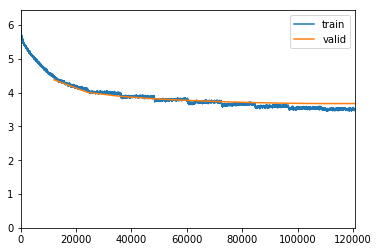

In [27]:
learner.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

เซฟโมเดลเก็บไว้ก่อน

In [28]:
learner.save('04a-learner_language_model-2')

In [20]:
learner.load('04a-learner_language_model-2');

ลองดูผลลัพธ์โดยการ ลองให้โมเดลสร้างประโยค 40 คำ จำนวน 2 ประโยค ที่เริ่มต้นด้วย TEXT

In [21]:
TEXT = "This movie is so"
N_WORDS = 40
N_SENTENCES = 2

เพื่อให้ประโยคที่ออกมาไม่ใช่ประโยคซ้ำ ๆ กัน จะมีการกำหนด temperature คือ ยิ่งมากยิ่งเพิ่มความ Random หลากหลายของประโยค

In [22]:
print("\n".join(learner.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie is so incredibly bad that it 's hard to believe that it was made in France . The acting is atrocious and the plot is not even believable . The cast is the worst ever - Christopher
This movie is so bad , i do n't even know who to blame . The plot is so small , and yet every single part of the movie is boring . It 's as if the director pushed the button close


จะเห็นได้ว่าเหมือนรีวิวหนังจริง ๆ 

In [23]:
TEXT = "The only complaint about this film is"
N_WORDS = 40
N_SENTENCES = 2

เพื่อให้ประโยคที่ออกมาไม่ใช่ประโยคซ้ำ ๆ กัน จะมีการกำหนด temperature คือ ยิ่งมากยิ่งเพิ่มความ Random หลากหลายของประโยค

In [24]:
print("\n".join(learner.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))


The only complaint about this film is that i did n't like it at all . It was boring , and i do n't understand why it went down as a movie ! 
 
  The actors playing Jesus and Jesus ' father were
The only complaint about this film is that there are too many clichés to describe . My friends and i seemed to like this film because it had some interesting potential . But it was so dull , that it left a bad taste in


เซฟ Encoder ไว้ใช้สร้าง โมเดล Classifier ต่อไป

ภายใน Language Model จะแบ่งเป็นครึ่ง Encoder และ Decoder ในกรณีนี้เราจะใช้แค่ Encoder เท่านั้น ไว้เราจะอธิบายต่อไป

In [32]:
learner.save_encoder('04a-encoder_language_model')


# 6. สร้างโมเดล Classifier

ต่อมาเราจะสร้างโมเดลที่ใช้จำแนก ว่ารีวิวนี้ เป็นแง่บวก หรือแง่ลบ

โหลดข้อมูลรีวิวตัวเต็ม ขึ้นมาใหม่

In [25]:
path = untar_data(URLs.IMDB)

สร้าง databunch จากรีวิวตัวเต็ม

1. ให้เอารีวิวทุกไฟล์ from_folder จากในโฟล์เดอร์ path
2. กำหนดให้โมเดล ใช้ vocab เดียวกับ Language Model ที่เราเทรนด้านบน
3. split_by_folder ให้ใช้ข้อมูลจากโฟล์เดอร์ test เป็น Validation Set
4. label_from_folder แยก label จากโฟล์เดอร์ neg, pos เหมือน imagenet เคสนี้มี 2 class
5. bs Batch Size 

แปลงข้อมูล Tokenize, Numericalize ให้เรียบร้อย แล้วเซฟไว้ก่อน

In [35]:
databunch_classifier = (TextList.from_folder(path, vocab=databunch_languagemodel.vocab)
             .split_by_folder(valid='test')
             .label_from_folder(classes=['neg', 'pos'])
             .databunch(bs=batchsize))

databunch_classifier.save('04a-databunch_classifier.pkl')

In [26]:
databunch_classifier = load_data(path, '04a-databunch_classifier.pkl', bs=batchsize)


ลองดูข้อมูล

In [27]:
databunch_classifier.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj berlin - born in 1942 xxmaj margarethe von xxmaj trotta was an actress and now she is a very important director and writer . xxmaj she has been described , perhaps even unfairly caricatured , as a director whose commitment to bringing a woman 's sensibility to the screen outweighs her artistic strengths . "" xxmaj rosenstrasse , "" which has garnered mixed and even strange reviews (",pos
"xxbos xxup warning : xxup possible xxup spoilers ( but not really - keep reading ) . xxmaj ahhh , there are so many reasons to become utterly addicted to this spoof gem that i wo n't have room to list them all . xxmaj the opening credits set the playful scene with kitsch late 1950s cartoon stills ; an enchanting xxmaj xxunk ' xxmaj prez ' xxmaj prado mambo",pos
"xxbos xxmaj pier xxmaj paolo xxmaj pasolini , or xxmaj pee - pee - pee as i prefer to call him ( due to his love of showing male genitals ) , is perhaps xxup the most overrated xxmaj european xxmaj marxist director - and they are thick on the ground . xxmaj how anyone can see "" art "" in this messy , cheap sex - romp concoction is",neg
"xxbos xxmaj perspective is a good thing . xxmaj since the release of "" xxmaj star xxmaj wars xxmaj episode i : xxmaj the xxmaj phantom xxmaj menace "" , claims and counter - claims of just how xxmaj episode 's xxup ii and xxup iii will xxunk has taken the spotlight off the ' original ' xxmaj star xxmaj wars films , making them part of a cohesive whole",pos


# 7. เริ่มต้นเทรน Classifier

สร้าง learner ด้วย AWD_LSTM โดยโหลด Encoder ที่เราเทรน และเซฟไว้ด้านบน

In [28]:
learner = text_classifier_learner(databunch_classifier, 
                                  AWD_LSTM, drop_mult=0.5, 
                                  callback_fns=ShowGraph).to_fp16()
learner.load_encoder('04a-encoder_language_model')

fit ด้วย Learning Rate สูง เพราะเทรนแค่ Layer สุดท้าย

epoch,train_loss,valid_loss,accuracy,time
0,0.239484,0.173695,0.936040,04:01


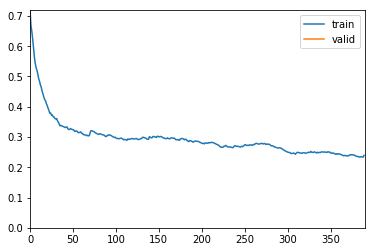

In [39]:
learner.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

เซฟโมเดลไว้ก่อน

In [40]:
learner.save('04a-learner_text_classifier-1')

In [41]:
learner.load('04a-learner_text_classifier-1');

# 8. เทรน Classifier ต่อ

unfreeze layer สุดท้าย และรองสุดท้าย ลดขนาด Batch Size

In [42]:
learner.freeze_to(-2)
databunch_classifier.batch_size=batchsize//2

ลด Learning Rate แล้วเทรนต่อ

epoch,train_loss,valid_loss,accuracy,time
0,0.235802,0.158436,0.941560,05:06


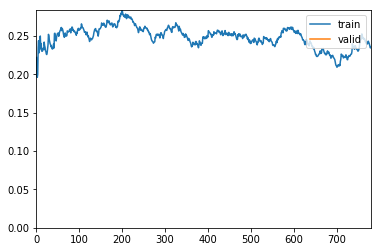

In [44]:
lrs = slice(1e-2/(2.6**4),1e-2)
learner.fit_one_cycle(1, lrs, moms=(0.8,0.7))

เซฟโมเดลไว้ก่อน

In [45]:
learner.save('04a-learner_text_classifier-2')

In [46]:
learner.load('04a-learner_text_classifier-2');

unfreeze 3 layer สุดท้าย 

In [47]:
learner.freeze_to(-3)

ลด Learning Rate แล้วเทรนต่อ

epoch,train_loss,valid_loss,accuracy,time
0,0.207390,0.144068,0.946520,07:06


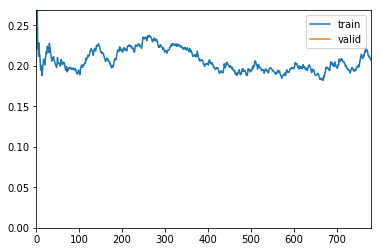

In [48]:
learner.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

เซฟโมเดลไว้ก่อน

In [49]:
learner.save('04a-learner_text_classifier-3')

In [29]:
learner.load('04a-learner_text_classifier-3');

unfreeze ทุก layer 

In [51]:
learner.unfreeze()

ลด Learning Rate แล้วเทรนต่ออีก

epoch,train_loss,valid_loss,accuracy,time
0,0.181044,0.140267,0.948960,08:43
1,0.142503,0.142641,0.950160,08:41


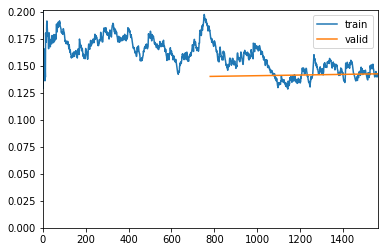

In [52]:
learner.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

## สำเร็จแล้ว

12 hours 95%

เซฟโมเดลไว้ก่อน

In [53]:
learner.save('04a-learner_text_classifier-4')

In [30]:
learner.load('04a-learner_text_classifier-4');

# 9. ดูผลลัพธ์

In [31]:
learner.predict("A movie which is so beautifully portrayed and is so hopeful that it won't let you take your eyes off it.")

(Category pos, tensor(1), tensor([0.0048, 0.9952]))

In [32]:
learner.predict("This movie is a complete mess. Everything about this movie sucks.")

(Category neg, tensor(0), tensor([9.9997e-01, 3.1942e-05]))

# 10. สรุป


1. การเทรนโมเดลหลัก ๆ จะคล้าย ๆ กัน แต่ Language Model ค่อนข้างใช้เวลาในการเทรนนาน ขนาดแค่เราเทรนกับรีวิวหนังอย่างเดียว ใช้เวลาก็ใช้เวลาไปถึง 12 ชั่วโมง แนะนำให้เทรนแล้วเซฟไว้เป็นสเต็ป เพื่อใช้ในคราวต่อ ๆ ไป ไม่ต้องเริ่มเทรนใหม่ทุกครั้ง
2. เราสามารถใช้วิธี ULMFiT นำ Transfer Learning มาช่วยลดเวลาในสร้างโมเดล NLP และยังช่วยให้โมเดลมีความแม่นยำมากขึ้นด้วย
3. ในยุคโซเชียล ที่เราหาข้อมูลแบบ Unstructure แบบนี้ได้จากอินเตอร์เน็ตแบบไม่จำกัด เราสามารถนำโมเดลแบบนี้ไปประยุกต์ใช้ในงานได้อย่างหลากหลาย 


# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 3](https://course.fast.ai/videos/?lesson=3)
* Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). [Learning Word Vectors for Sentiment Analysis.]((http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf)) The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).
* [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182)
* Stephen Merity, Caiming Xiong, James Bradbury, and Richard Socher. 2016. [Pointer Sentinel Mixture Models](http://arxiv.org/abs/1609.07843)